# Ejercicio resuelto en clase. Atari: Assault

In [1]:
import sys

sys.version

'3.10.13 (main, Sep 11 2023, 13:21:10) [GCC 11.2.0]'

In [2]:
import gymnasium as gym
import matplotlib.pyplot as plt
from keras import layers, Model
import keras
import numpy as np
import tensorflow as tf
from collections import deque
import random

2024-06-27 21:55:36.738301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


((210, 160), {'lives': 4, 'episode_frame_number': 0, 'frame_number': 0})

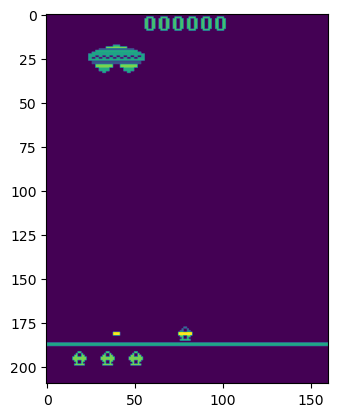

In [3]:
gym_name = "ALE/Assault-v5"
env = gym.make(gym_name, obs_type="grayscale")
s0, info = env.reset()


plt.imshow(s0)
s0.shape, info

Probar episodio random

50 0.0 {'lives': 4, 'episode_frame_number': 200, 'frame_number': 200}


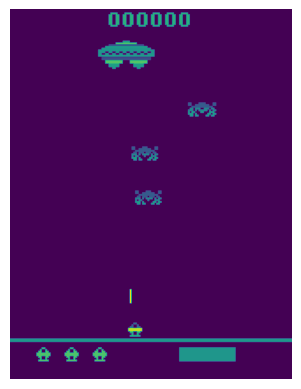

100 42.0 {'lives': 4, 'episode_frame_number': 400, 'frame_number': 400}


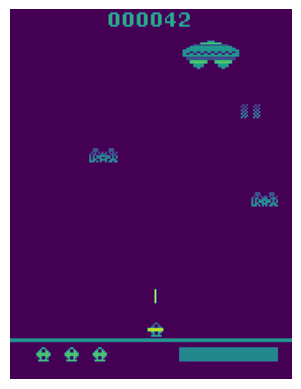

150 105.0 {'lives': 3, 'episode_frame_number': 600, 'frame_number': 600}


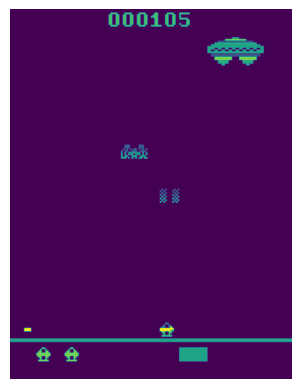

200 147.0 {'lives': 3, 'episode_frame_number': 800, 'frame_number': 800}


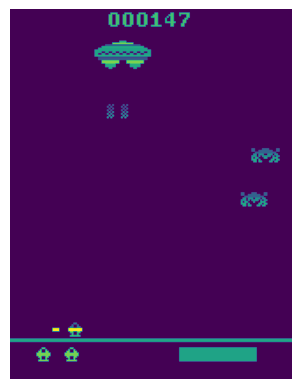

250 168.0 {'lives': 3, 'episode_frame_number': 1000, 'frame_number': 1000}


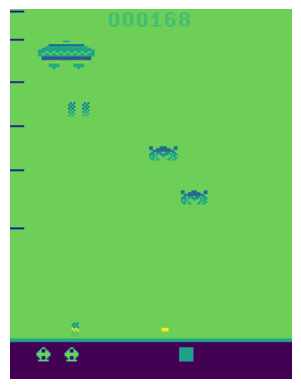

300 189.0 {'lives': 2, 'episode_frame_number': 1200, 'frame_number': 1200}


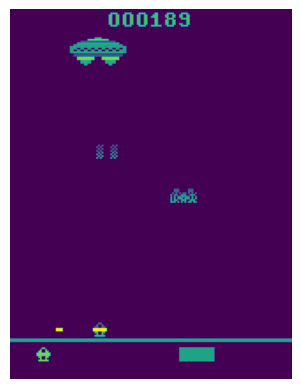

350 189.0 {'lives': 2, 'episode_frame_number': 1400, 'frame_number': 1400}


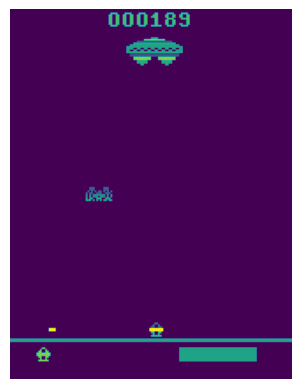

400 210.0 {'lives': 2, 'episode_frame_number': 1600, 'frame_number': 1600}


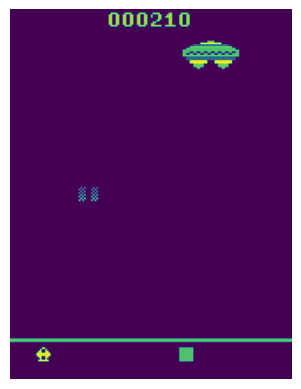

450 210.0 {'lives': 1, 'episode_frame_number': 1800, 'frame_number': 1800}


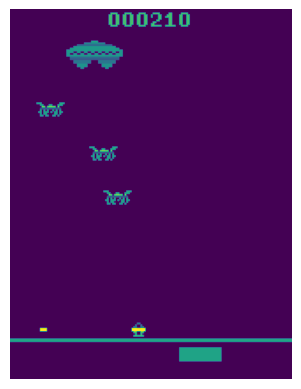

500 231.0 {'lives': 1, 'episode_frame_number': 2000, 'frame_number': 2000}


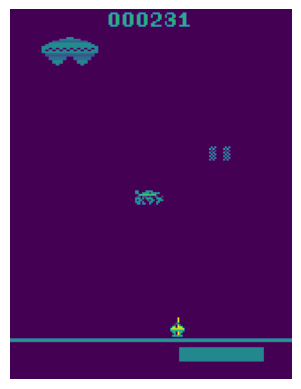

550 252.0 {'lives': 1, 'episode_frame_number': 2200, 'frame_number': 2200}


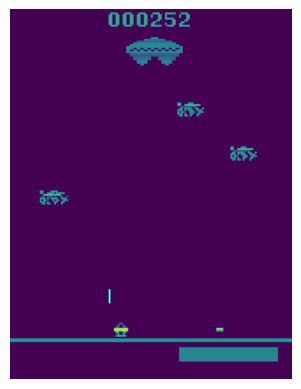

In [4]:
experiences = []
count = 0
r_sum = 0
s0 = env.reset()

while True:
    #Elegimos acción aleatoria con sample
    action = env.action_space.sample()
    #Hacemos el próximo paso con el método step.
    next_state, reward, terminated, truncated, info = env.step(action)
    #Guardamos en una lista de listas todos los datos que obtenemos de cada paso
    experiences.append([s0, action, next_state, reward, terminated, truncated, info])

    #Actualizamos cómo el estado actual el "próximo estado", el número de acciones que hemos hecho y el reward total.
    s0 = next_state
    count += 1
    r_sum += reward

    # si hemos acabado el episodio o se trunca (llegamos al número máximo de acciones programado), terminamos el bucle.
    if terminated or truncated:
        break
    # cada 20 episodios mostramos el nº episodio, la recompensa acumulada y la información del estado
    if count % 50 == 0:
        print(count, r_sum, info)

        #Para mostrar la imágen hay que usar matplotlib 
        plt.imshow(s0)
        plt.axis('off')
        plt.show()

In [5]:
s0, info = env.reset()

In [6]:
def state_to_tensor(state):
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    return state

In [7]:
def create_q_model():
    # Definir el tamaño de los inputs
    inputs = layers.Input(shape=(*s0.shape, 1))

    #Definir la red neuronal

    layer1 = layers.Conv2D(32, 8, strides=4, activation='relu')(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation='relu')(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation='relu')(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(256, activation='relu')(layer4)
    action = layers.Dense(env.action_space.n, activation='linear')(layer5)

    return keras.Model(inputs=inputs, outputs=action)
    

Doble DQN

In [8]:
decay = 0.9999
epsilon_ini = 1.0
epsilon_end = 0.05
learning_rate = 0.001
gamma = 0.999
max_memory_size = int(10e5)
batch_size = 16


In [9]:
import keras.optimizers


q_model = create_q_model()
t_model = create_q_model()

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
q_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 210, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 51, 39, 32)        2080      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 18, 64)        32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 16, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 22528)             0         
                                                                 
 dense (Dense)               (None, 256)               5767424   
                                                                 
 dense_1 (Dense)             (None, 7)                 1799  

Elegir mejor acción

In [10]:
def get_best_action(state):
    q_state = q_model(state)
    return np.argmax(q_state)

Elegir parámetros

In [11]:
# Esto no sé para qué se hace

s0_b = np.expand_dims(s0, axis=0)
q0_b = q_model(s0_b)
q0_b

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[ 2.351171  , -0.97876126, -2.8502913 ,  2.3007412 , -1.1520963 ,
        -0.29962695, -2.3106668 ]], dtype=float32)>

Tensorboard

In [64]:
import datetime
import os

implementation = 'DQN_ATARI_ASSAULT_V0'
current_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
train_log_dir = os.path.join('logs', gym_name, implementation, 'T_' + current_time)

In [65]:
%load_ext tensorboard
%tensorboard --logdir ./logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 20022), started 0:03:54 ago. (Use '!kill 20022' to kill it.)

# Entrenar al modelo (bucle principal)
1. Resetear environment
2. Generar experiencias hasta terminar el episodio
3. Tras generar el episodio, hay que entrenar

In [13]:
memory = deque(maxlen=max_memory_size)

episode = 0
epoque = 0
epsilon = epsilon_ini
agent_eval = 0

while True:
    #Begin episode
    s0, info = env.reset()
    #Convertimos s0 a las dimensiones que necesitamos
    s0_b = np.expand_dims(s0, axis=0)
    
    #El próximo bucle es el generador de experiencias. Aquíe también entrenamos(se puede entrenar en otros sitios, pero elegimos entrenar tras cada acción.)
    while True:
        #Select action
        #Cómo actuamos con epsilon greedy, sacamos un número al azar de 0 a 1.
        if np.random.random() < epsilon:
            #Si es menor que el epsilon, elegiremos una acción al azar
            action = env.action_space.sample()
        else:
            #Si es mayor que el epsilon, elegiremos la mejor acción según el modelo
            q0_b = q_model(s0_b) #Esto, loq ue hace es pasar el estado actual como input al modelo y obtenemos un tensor con la probabilidad de cada acción
            action = np.argmax(q0_b)
        
        #Ajustar el epsilon. Hay estudiar las mejores técnicas para esto. Por ejemplo, si ves que olvidas, se puede aumentar el epsilon
        if epsilon > epsilon_end:
            epsilon *= decay
        else:
            epsilon = epsilon_end
        #Una vez elegida la acción hacemos el próximo paso con el método step.
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = np.expand_dims(next_state, axis=0)

        #Guardar la experiencia
        experience = (s0_b, action, next_state, reward, terminated, truncated)
        memory.append(experience)

        ####################
        #####TRAIN MODEL####
        ####################

        if len(memory) >= batch_size: #Importante tener al menos el número de experiencias que queremos para entrenar
            samples = random.sample(memory, batch_size-1)
            samples.append(memory[-1])

            #Para entrenar 1 a 1
            with tf.GradientTape() as tape:
               loss = 0
               q_max_list = []
               for s0_b_, a_, s1_b_, r_, d_, t_ in samples:
                    #Ec Bellman: q_0 = r + gamma*q_1*not(d)

                    #Cogemos la acción con q máxima para 2 estados después.
                    q_next = np.max(q_model(s1_b_))
                    q_bellman = r_ + gamma * q_next * (1-d_)
                    q_current = q_model(s0_b_)[0, a_]
                    loss += (q_current - q_bellman)**2
                    q_max_list.append(q_current)


               loss_mean = loss / batch_size

               #Backpropagation
               grads = tape.gradient(loss, q_model.trainable_variables)
               optimizer.apply_gradients(zip(grads, q_model.trainable_variables))
               
            q_max = np.max(q_max_list)

            # with summary_writer.as_default():
            #     tf.summary.scalar('loss', loss_mean, step = epoque)
            #     tf.summary.scalar('ema_reward_eval', agent_eval ,step=epoque)
            #     tf.summary.scalar('epsilon', epsilon ,step=epoque)
            #     tf.summary.scalar('ema_reward_eval', q_max ,step=epoque)

            epoque += 1

        s0_b = next_state

        if truncated or terminated:

            break

    episode += 1

    if episode > 1:
        break

s0_eval = env.reset()
s0_b_eval = np.expand_dims(s0, axis = 0)
r_sum_eval = 0
while True:

    q0_b_eval = q_model(s0_b_eval) #Esto, loq ue hace es pasar el estado actual como input al modelo y obtenemos un tensor con la probabilidad de cada acción
    action_eval = np.argmax(q0_b_eval)
    s1_eval, reward_eval, term_eval, trunc_eval, _ = env.step(action)

    s1_eval = np.expand_dims(s1_eval, axis=0)
    s0_b_eval = s1_eval
    r_sum_eval += reward_eval
    if term_eval or trunc_eval:
        print(f'End of episode: terminated: {terminated} truncated: {truncated}')
        break

agent_eval = r_sum

KeyboardInterrupt: 

In [ ]:
samples[1]

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 6,
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 0.0,
 False,
 False)